# MDI+: Example Usages

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error
import copy

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [2]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [3]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [4]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [5]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.3636246290125099

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [6]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.608185  0.550630  0.020854  0.045005  0.096493  0.077575  0.115203   
1    0.636225  0.492562  0.015898  0.070490  0.089043  0.059321  0.151142   
2    0.664347  0.708128  0.051095  0.050765  0.100931  0.065101  0.051117   
3    0.755061  0.660813  0.031509  0.053803  0.133723  0.055421  0.115279   
4    0.725802  0.657923  0.043663  0.085427  0.113600  0.063547  0.057758   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.802217  0.555734  0.057806  0.073170  0.150834  0.046640  0.054222   
130  0.737610  0.525766  0.020153  0.059622  0.115602  0.039295  0.096992   
131  0.759395  0.754096  0.035229  0.065062  0.091480  0.090577  0.055108   
132  0.546094  0.658316  0.022907  0.063193  0.088292  0.054754  0.088160   
133  0.744669  0.766035  0.048084  0.055177  0.093

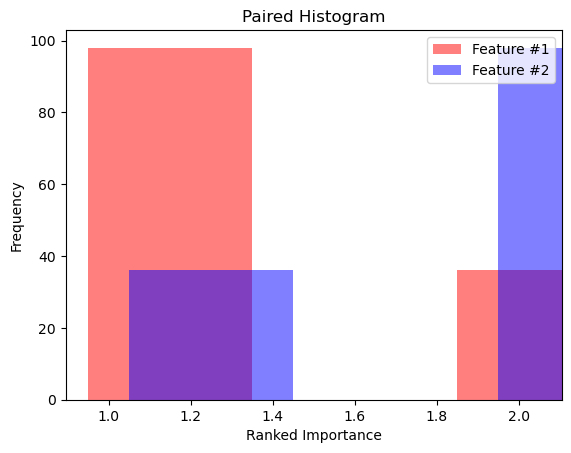

In [7]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [8]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.422315  0.425202  0.020069  0.039757  0.090442  0.069194  0.098220   
1    0.467669  0.360619  0.015183  0.056617  0.074321  0.051299  0.135890   
2    0.470798  0.634474  0.046767  0.041558  0.081441  0.059472  0.040333   
3    0.735644  0.642640  0.030044  0.047706  0.120986  0.051880  0.106644   
4    0.501932  0.589312  0.042987  0.081045  0.109697  0.054156  0.053157   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.735409  0.487187  0.057017  0.064289  0.145858  0.044710  0.044878   
130  0.662528  0.497686  0.018442  0.052805  0.104725  0.036073  0.080771   
131  0.722433  0.736415  0.034158  0.058703  0.078662  0.085876  0.050006   
132  0.422830  0.633389  0.020639  0.058062  0.085350  0.053636  0.078052   
133  0.512170  0.724235  0.047081  0.048256  0.071

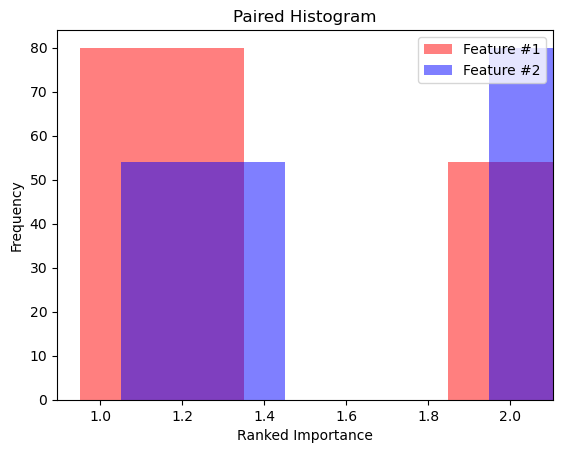

In [9]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}$

In [10]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtraincopy = copy.deepcopy(X_train)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")
# check if X_train has been modified
print(np.array_equal(X_train, Xtraincopy))

True


In [11]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtestcopy = copy.deepcopy(X_test)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
                                                    lfi_abs = "none", train_or_test = "test",
                                                    sample_split = None)
# check if X_test has been modified
print(np.array_equal(X_test, Xtestcopy))

True


Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
           0         1         2         3         4         5         6  \
0  -0.612518 -0.233865 -0.019366 -0.005137  0.013640 -0.026954 -0.057513   
1  -0.616848  0.241251  0.014381 -0.025470  0.037838 -0.005244  0.039499   
2   0.250852  0.220097 -0.013537  0.015817  0.122494 -0.009855  0.024375   
3   0.398347  0.398843 -0.003681  0.108051 -0.097339  0.022152 -0.005007   
4  -0.420028 -0.721166 -0.013371 -0.022331  0.023841 -0.040975  0.046131   
..       ...       ...       ...       ...       ...       ...       ...   
61 -0.541249  0.327067  0.007995 -0.032408 -0.064986  0.010670  0.032212   
62  0.286810 -0.761167 -0.017463 -0.051808 -0.060441 -0.015466 -0.036604   
63  0.465622 -0.638668 -0.022841 -0.046794  0.206094 -0.038479 -0.009107   
64 -0.281037 -0.791475  0.031824 -0.026122 -0.070774 -0.002338 -0.030279   
65 -0.613498  0.180568 -0.013571 -0.015026  0.064937 -0.00669

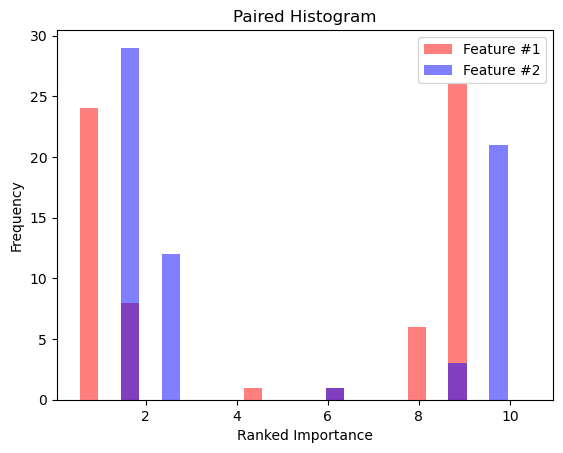

In [12]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()